# Information Globale

## Importation

In [1]:
#Générique Importation
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

#Générique Importation
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

#
from vacances_scolaires_france import SchoolHolidayDates

#Sclaing
from sklearn.preprocessing import RobustScaler

#Machine Learning
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from lineartree           import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

#Vizualisation
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})


#Preprocessing Interne
from analyse.preproc import preprocessing_RTE_encours, preproc_temperature_ENEDIS, preproc_tempo
from analyse.feat_eng import add_schoolholidays, add_weekday, add_public_holidays


%load_ext autoreload
%autoreload 2

In [2]:
# Data Import
## Puissance
df_final = pd.read_csv('data_final/data_final.csv')
df_final.head()

,date_hour,Consommation,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,sin_mois,cos_mois,sin_jour,cos_jour,...,temperature_realisee_lissee_degc_shift19,temperature_realisee_lissee_degc_shift20,temperature_realisee_lissee_degc_shift21,temperature_realisee_lissee_degc_shift22,temperature_realisee_lissee_degc_shift23,temperature_realisee_lissee_degc_shift24,temperature_realisee_lissee_degc_shift25,Type de jour TEMPO_BLANC,Type de jour TEMPO_BLEU,Type de jour TEMPO_ROUGE
0,2022-06-02 00:30:00,42420.0,0,0,16.9,2022,1.224647e-16,-1.0,0.394356,0.918958,...,19.9,19.7,19.5,19.3,19.1,18.9,18.7,0.0,1.0,0.0
1,2022-06-02 01:00:00,40356.0,0,0,16.8,2022,1.224647e-16,-1.0,0.394356,0.918958,...,19.8,19.9,19.7,19.5,19.3,19.1,18.9,0.0,1.0,0.0
2,2022-06-02 01:30:00,40299.0,0,0,16.8,2022,1.224647e-16,-1.0,0.394356,0.918958,...,19.7,19.8,19.9,19.7,19.5,19.3,19.1,0.0,1.0,0.0
3,2022-06-02 02:00:00,39840.0,0,0,16.8,2022,1.224647e-16,-1.0,0.394356,0.918958,...,19.6,19.7,19.8,19.9,19.7,19.5,19.3,0.0,1.0,0.0
4,2022-06-02 02:30:00,38895.0,0,0,16.8,2022,1.224647e-16,-1.0,0.394356,0.918958,...,19.4,19.6,19.7,19.8,19.9,19.7,19.5,0.0,1.0,0.0


## Train Test Split

In [3]:
n = 70 #Number of predictions that we want, with 30 min step

train = df_final.iloc[:-n]
test = df_final.iloc[-n:]


date_train = train.date_hour
X_train = train.drop(columns=['Consommation','date_hour'])
y_train = train.Consommation

date_test = test.date_hour
X_test = test.drop(columns=['Consommation','date_hour'])
y_test = test.Consommation

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(30983, 91) (70, 91) (30983,) (70,)


## Scaling

In [4]:
# Step 0 - Instanciate Robust Scale
rb_scaler = RobustScaler()

# Step 1- Fit the scaler
rb_scaler.fit(X_train)

# 2-Scale/Transform
X_train_scaled = rb_scaler.transform(X_train)
X_test_scaled = rb_scaler.transform(X_test)


# Modélisation over 2 days

## Modélisation 1 : HistGradientBoostingRegressor

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/1123497363.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = regressor.predict(X_test_scaled)


([<matplotlib.axis.XTick at 0x166412230>,
 [Text(0, 0, ''), Text(0, 0, '')])

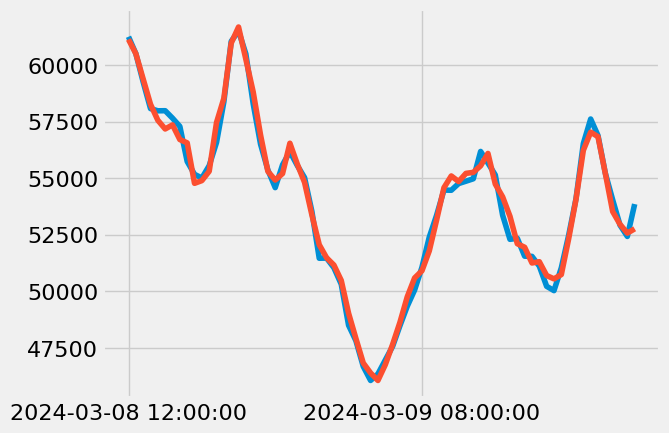

In [5]:
#0.6sec
regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train_scaled, y_train)

test["predictions"] = regressor.predict(X_test_scaled)
plt.plot(date_test,test[['Consommation','predictions']])
plt.xticks(np.arange(0, n, step=40))

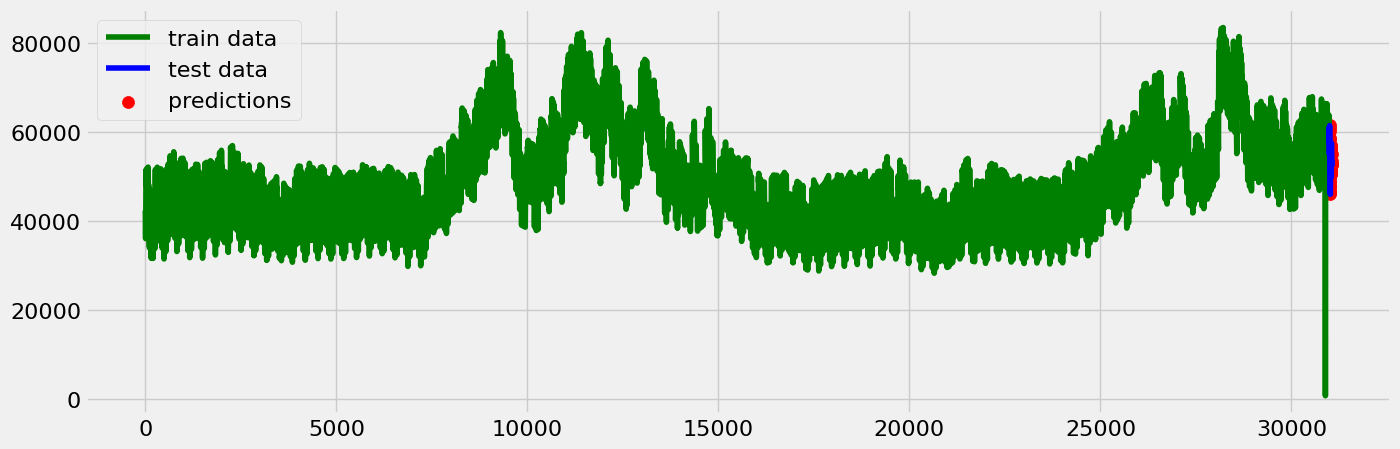

In [6]:
#Fig Globale
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["Consommation"], label='train data', color="green")
ax.plot(test.index,test["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
ax.legend(loc="upper left")

plt.show();

In [7]:
MAE_HGBR = mean_squared_error(test["Consommation"],test["predictions"])
MAPE_HGBR = mean_absolute_percentage_error(test["Consommation"],test["predictions"])

print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

MSE = 1.686e+05
MAPE = 0.00607


In [8]:
# Ante-Circular/Shift Values
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

MSE = 1.686e+05
MAPE = 0.00607


## Modélisation 2 : avec LinearBoostRegressor

https://github.com/cerlymarco/linear-tree

In [9]:
#1m8sec
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 100,
                                 max_depth    = 3,
                                 random_state = 42)

regressor.fit(X_train_scaled, y_train)
test["predictions_Linear"] = regressor.predict(X_test_scaled)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/1168915452.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_Linear"] = regressor.predict(X_test_scaled)


([<matplotlib.axis.XTick at 0x1665a27a0>,
 [Text(0, 0, ''), Text(0, 0, '')])

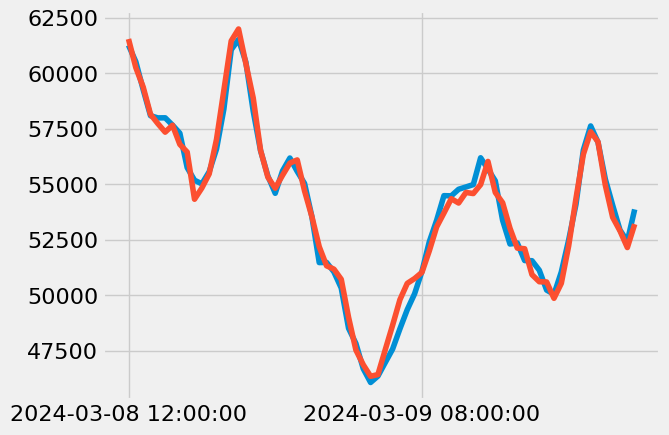

In [10]:
plt.plot(date_test,test[['Consommation','predictions_Linear']],)
plt.xticks(np.arange(0, n, step=40))

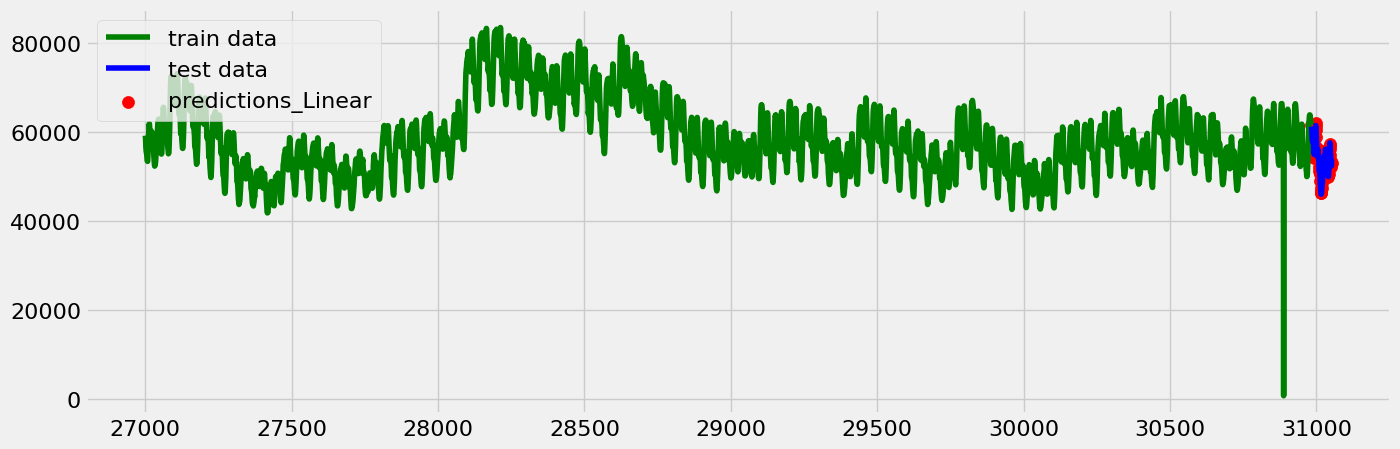

In [11]:
#Zoom sur l'ensemble
train_zoom = train[27000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_Linear"], label='predictions_Linear', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [12]:
MAE_LBR = mean_squared_error(test["Consommation"],test["predictions_Linear"])
MAPE_LBR = mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"])

print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"]))

MSE = 2.51e+05
MAPE = 0.007555


## Modélisation 3 : GradientBoostingRegressor

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/1333553459.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_GBR"] = regressor.predict(X_test_scaled)


([<matplotlib.axis.XTick at 0x166698430>,
 [Text(0, 0, ''), Text(0, 0, '')])

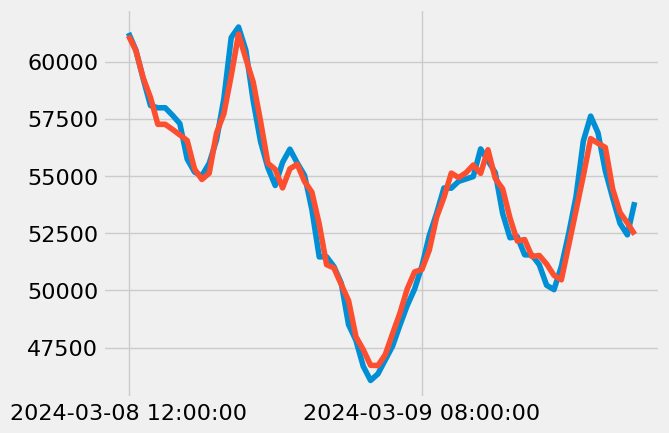

In [13]:
#0.6sec
regressor = GradientBoostingRegressor(n_estimators=100)
regressor.fit(X_train_scaled, y_train)

test["predictions_GBR"] = regressor.predict(X_test_scaled)

plt.plot(date_test,test[['Consommation','predictions_GBR']],)
plt.xticks(np.arange(0, n, step=40))

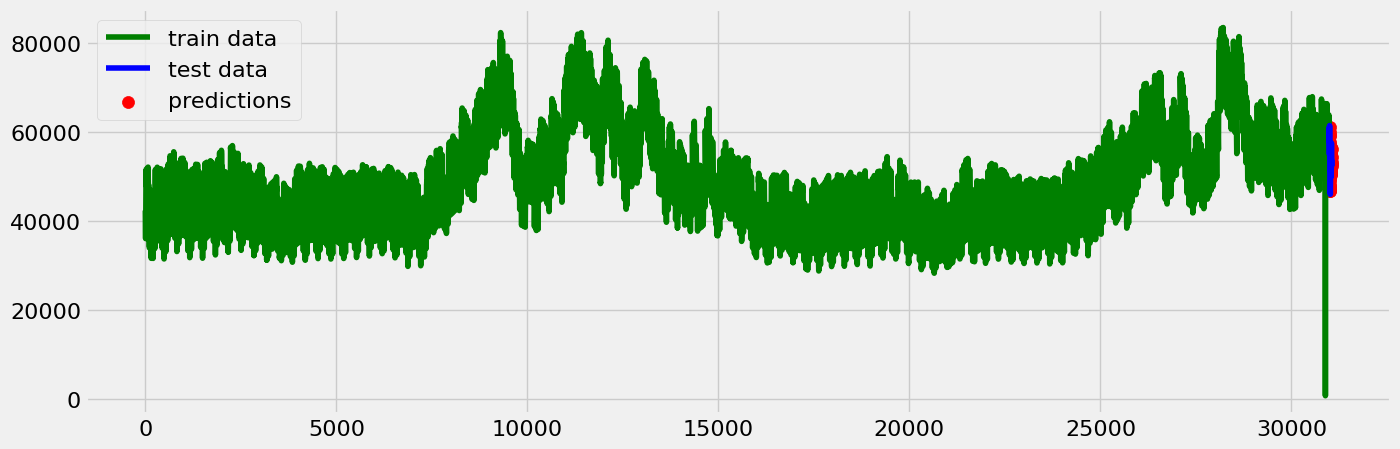

In [14]:
#Fig Globale
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["Consommation"], label='train data', color="green")
ax.plot(test.index,test["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test.index, test["predictions_GBR"], label='predictions', color="red", s=75)
ax.legend(loc="upper left")

plt.show();

In [15]:
MAE_GBR = mean_squared_error(test["Consommation"],test["predictions_GBR"])
MAPE_GBR = mean_absolute_percentage_error(test["Consommation"],test["predictions_GBR"])


print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_GBR"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_GBR"]))

MSE = 4.536e+05
MAPE = 0.01042


## Modélisation 4 : XGBOOST

In [16]:
import xgboost as xgb

[16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/529306233.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_xgb"] = model.predict(dtest)


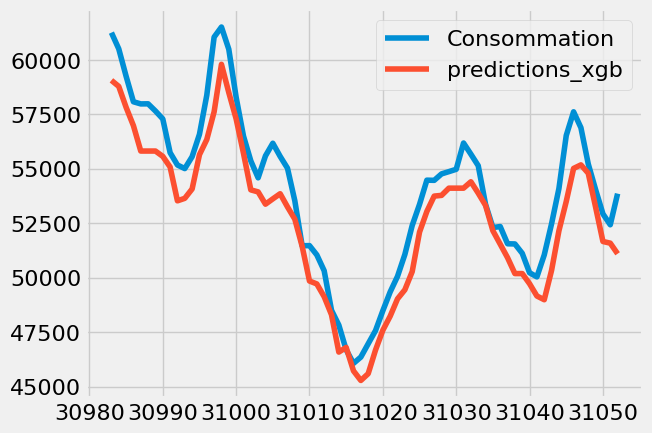

In [17]:
# #0.6sec

params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'n_estimators': 150
}

dtrain = xgb.DMatrix(data=X_train_scaled, label=y_train)
dtest = xgb.DMatrix(data=X_test_scaled, label=y_test)


model = xgb.train(params=params, dtrain=dtrain)

test["predictions_xgb"] = model.predict(dtest)
test[['Consommation','predictions_xgb']].plot();

# ## Essayer d'ajouter les bonnes valeurs des heures pour meilleures compréhension

In [18]:
MAE_XBG = mean_squared_error(test["Consommation"],test["predictions_xgb"])
MAPE_XGB = mean_absolute_percentage_error(test["Consommation"],test["predictions_xgb"])


print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_xgb"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_xgb"]))

MSE = 2.319e+06
MAPE = 0.02458


## Comparison Result 2 Days

In [19]:
MAE = [MAE_HGBR,MAE_LBR,MAE_GBR,MAE_XBG]
MAPE = 100*np.array([MAPE_HGBR,MAPE_LBR,MAPE_GBR,MAPE_XGB])
models = ['HGBR','LBR',"GBR",'XGB']
pd.DataFrame({"Modele":models,"MAE":MAE,"MAPE (%)":MAPE}).sort_values('MAPE (%)')

,Modele,MAE,MAPE (%)
0,HGBR,1.685564e+05,0.606953
1,LBR,2.510490e+05,0.755455
2,GBR,4.535578e+05,1.042417
3,XGB,2.319027e+06,2.457981


We can see that the most interesting model is the HGBR. It would be interesting to compare their accuracy on a larger DataSet and not just over 1 day.

# Comparison of results for each 2 days over 1 month apart (always stritcly 1 year's train)

In [21]:
X = df_final.drop(columns='Consommation')
y = df_final[['Consommation']]

n_glob = X.shape[0] #Taille de l'ensemble

params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'n_estimators': 150
    }

MAE_HGBR_month = []
MAE_LBR_month = []
MAE_GBR_month = []
MAE_XGB_month = []

MAPE_HGBR_month = []
MAPE_LBR_month = []
MAPE_GBR_month = []
MAPE_XGB_month = []

for k in range(32,2,-1):
    print(f"---------- Jour numéro {33-k} ----------")

    X_train = X.iloc[ -48*365 - 48*k : - 48*k ]
    X_test = X.iloc[ - 48*k : - 48*(k-2)] #On effectue le test sur 2 jour de prédiction

    y_train = y.iloc[-48*365 - 48*k : - 48*k ]
    y_test = y.iloc[ - 48*k : - 48*(k-2) ] #On effectue le test sur 2 jour de prédiction

    print(f"---------- Train entre {str(X_train[:1]['date_hour'])[9:27]} et {str(X_train[-1:]['date_hour'])[9:27]} ----------")
    print(f"---------- Test entre {str(X_test[:1]['date_hour'])[9:27]} et {str(X_test[-1:]['date_hour'])[9:27]} ----------")
    X_train = X_train.drop(columns='date_hour')
    X_test = X_test.drop(columns='date_hour')

    # Step 0 - Instanciate Robust Scale
    rb_scaler = RobustScaler()
    # Step 1- Fit the scaler
    rb_scaler.fit(X_train)
    # 2-Scale/Transform
    X_train_scaled = rb_scaler.transform(X_train)
    X_test_scaled = rb_scaler.transform(X_test)

    ########Calcul#######
    #HGBR
    regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)

    MAE_HGBR = mean_squared_error(y_test["Consommation"],y_test["predictions_HGBR"])
    MAPE_HGBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_HGBR"])

    MAE_HGBR_month.append(MAE_HGBR)
    MAPE_HGBR_month.append(MAPE_HGBR)

    #LBR
    regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 100,
                                 max_depth    = 3)

    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_Linear"] = regressor.predict(X_test_scaled)

    MAE_LBR = mean_squared_error(y_test["Consommation"],y_test["predictions_Linear"])
    MAPE_LBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_Linear"])

    MAE_LBR_month.append(MAE_LBR)
    MAPE_LBR_month.append(MAPE_LBR)

    #GBR
    regressor = GradientBoostingRegressor(n_estimators=200)
    regressor.fit(X_train_scaled, y_train)

    y_test["predictions_GBR"] = regressor.predict(X_test_scaled)

    MAE_GBR = mean_squared_error(y_test["Consommation"],y_test["predictions_GBR"])
    MAPE_GBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_GBR"])

    MAE_GBR_month.append(MAE_GBR)
    MAPE_GBR_month.append(MAPE_GBR)

    #XGB
    dtrain = xgb.DMatrix(data=X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(data=X_test_scaled, label=y_test)

    model = xgb.train(params=params, dtrain=dtrain)
    y_test["predictions_xgb"] = model.predict(dtest)

    MAE_XGB = mean_squared_error(y_test["Consommation"],y_test["predictions_xgb"])
    MAPE_XGB = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_xgb"])

    MAE_XGB_month.append(MAE_XGB)
    MAPE_XGB_month.append(MAPE_XGB)


---------- Jour numéro 1 ----------
---------- Train entre 2023-02-06 23:00:0 et 2024-02-06 22:30:0 ----------
---------- Test entre 2024-02-06 23:00:0 et 2024-02-08 22:30:0 ----------


/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

[17:05:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 2 ----------
---------- Train entre 2023-02-07 23:00:0 et 2024-02-07 22:30:0 ----------
---------- Test entre 2024-02-07 23:00:0 et 2024-02-09 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 3 ----------
---------- Train entre 2023-02-08 23:00:0 et 2024-02-08 22:30:0 ----------
---------- Test entre 2024-02-08 23:00:0 et 2024-02-10 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:09:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 4 ----------
---------- Train entre 2023-02-09 23:00:0 et 2024-02-09 22:30:0 ----------
---------- Test entre 2024-02-09 23:00:0 et 2024-02-11 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:11:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 5 ----------
---------- Train entre 2023-02-10 23:00:0 et 2024-02-10 22:30:0 ----------
---------- Test entre 2024-02-10 23:00:0 et 2024-02-12 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:12:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 6 ----------
---------- Train entre 2023-02-11 23:00:0 et 2024-02-11 22:30:0 ----------
---------- Test entre 2024-02-11 23:00:0 et 2024-02-13 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:14:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 7 ----------
---------- Train entre 2023-02-12 23:00:0 et 2024-02-12 22:30:0 ----------
---------- Test entre 2024-02-12 23:00:0 et 2024-02-14 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:16:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 8 ----------
---------- Train entre 2023-02-13 23:00:0 et 2024-02-13 22:30:0 ----------
---------- Test entre 2024-02-13 23:00:0 et 2024-02-15 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:18:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 9 ----------
---------- Train entre 2023-02-14 23:00:0 et 2024-02-14 22:30:0 ----------
---------- Test entre 2024-02-14 23:00:0 et 2024-02-16 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:19:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 10 ----------
---------- Train entre 2023-02-15 23:00:0 et 2024-02-15 22:30:0 ----------
---------- Test entre 2024-02-15 23:00:0 et 2024-02-17 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:21:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 11 ----------
---------- Train entre 2023-02-16 23:00:0 et 2024-02-16 22:30:0 ----------
---------- Test entre 2024-02-16 23:00:0 et 2024-02-18 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:23:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 12 ----------
---------- Train entre 2023-02-17 23:00:0 et 2024-02-17 22:30:0 ----------
---------- Test entre 2024-02-17 23:00:0 et 2024-02-19 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:25:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


---------- Jour numéro 13 ----------
---------- Train entre 2023-02-18 23:00:0 et 2024-02-18 22:30:0 ----------
---------- Test entre 2024-02-18 23:00:0 et 2024-02-20 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

[17:26:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 14 ----------
---------- Train entre 2023-02-19 23:00:0 et 2024-02-19 22:30:0 ----------
---------- Test entre 2024-02-19 23:00:0 et 2024-02-21 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:28:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 15 ----------
---------- Train entre 2023-02-20 23:00:0 et 2024-02-20 22:30:0 ----------
---------- Test entre 2024-02-20 23:00:0 et 2024-02-22 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:30:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 16 ----------
---------- Train entre 2023-02-21 23:00:0 et 2024-02-21 22:30:0 ----------
---------- Test entre 2024-02-21 23:00:0 et 2024-02-23 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[17:32:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 17 ----------
---------- Train entre 2023-02-22 23:00:0 et 2024-02-22 22:30:0 ----------
---------- Test entre 2024-02-22 23:00:0 et 2024-02-24 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_63458/3059901159.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

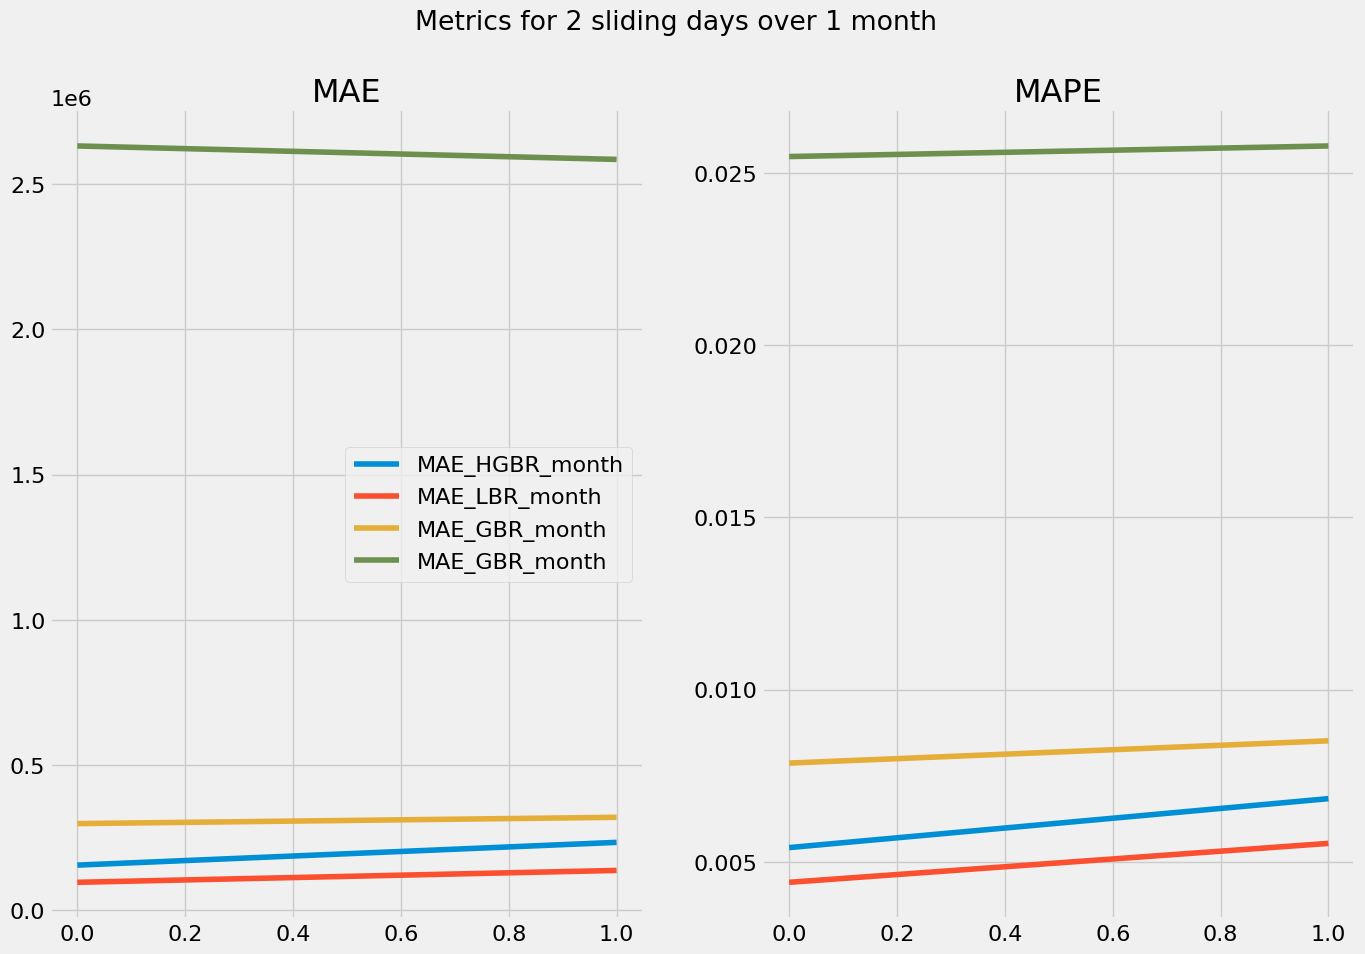

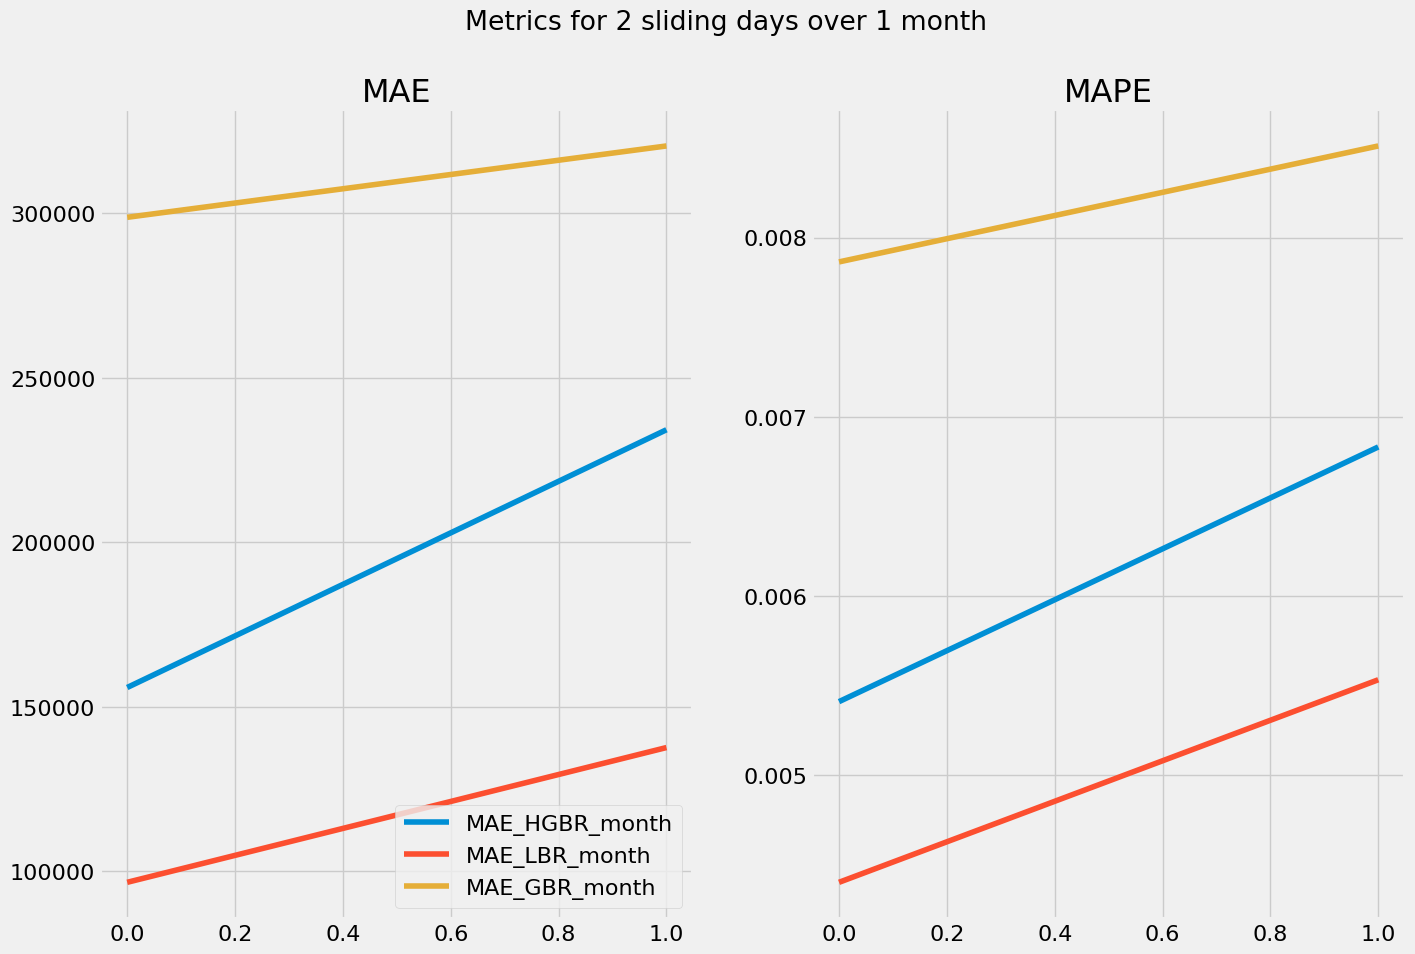

In [ ]:
### Graphique de l'ensemble des Metrics ###
fig = plt.figure(figsize=(15,10))
fig = plt.gcf()

# First subplot
ax1 = fig.add_subplot(1,2,1)
ax1.plot(MAE_HGBR_month, label="MAE_HGBR_month")
ax1.plot(MAE_LBR_month, label="MAE_LBR_month")
ax1.plot(MAE_GBR_month, label="MAE_GBR_month")
ax1.plot(MAE_XGB_month, label="MAE_GBR_month")
ax1.set_title('MAE')
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(1,2,2)
ax2.plot(MAPE_HGBR_month, label="MAPE_HGBR_month")
ax2.plot(MAPE_LBR_month, label="MAPE_LBR_month")
ax2.plot(MAPE_GBR_month, label="MAPE_GBR_month")
ax2.plot(MAPE_XGB_month, label="MAPE_XGB_month")
ax2.set_title('MAPE')

# Global figure methods
fig.suptitle('Metrics for 2 sliding days over 1 month ')
plt.show()

########################################################
########################################################

####### Graphic without XHBoost #######
fig = plt.figure(figsize=(15,10))
fig = plt.gcf()

# First subplot
ax1 = fig.add_subplot(1,2,1)
ax1.plot(MAE_HGBR_month, label="MAE_HGBR_month")
ax1.plot(MAE_LBR_month, label="MAE_LBR_month")
ax1.plot(MAE_GBR_month, label="MAE_GBR_month")
ax1.set_title('MAE')
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(1,2,2)
ax2.plot(MAPE_HGBR_month, label="MAPE_HGBR_month")
ax2.plot(MAPE_LBR_month, label="MAPE_LBR_month")
ax2.plot(MAPE_GBR_month, label="MAPE_GBR_month")
ax2.set_title('MAPE')

# Global figure methods
fig.suptitle('Metrics for 2 sliding days over 1 month ')
plt.show()


On se rend compte que plus on se rapproche de la fin du Data Set, plus les modèles sont imprécis.
Est-ce le nombre de données qui augmente et qui influence la prédiction.

In [ ]:
MAE = [np.mean(MAE_HGBR_month),np.mean(MAE_LBR_month),np.mean(MAE_GBR_month),np.mean(MAE_XGB_month)]
MAPE = 100*np.array([np.mean(MAPE_HGBR_month),np.mean(MAPE_LBR_month),np.mean(MAPE_GBR_month),np.mean(MAPE_XGB_month)])
models = ['HGBR','LBR',"GBR",'XGB']
pd.DataFrame({"Modele":models,"MAE":MAE,"MAPE (%)":MAPE}).sort_values('MAPE (%)')

,Modele,MAE,MAPE (%)
1,LBR,1.171839e+05,0.496910
0,HGBR,1.950640e+05,0.612224
2,GBR,3.096134e+05,0.818797
3,XGB,2.607712e+06,2.562226


# Comparison of results over 2 sliding days with 1 year and the previous days of the month

In [ ]:
X = df_final.drop(columns='Consommation')
y = df_final[['Consommation']]

n_glob = X.shape[0] #Taille de l'ensemble

params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'n_estimators': 150
    }

MAE_HGBR_month = []
MAE_LBR_month = []
MAE_GBR_month = []
MAE_XGB_month = []

MAPE_HGBR_month = []
MAPE_LBR_month = []
MAPE_GBR_month = []
MAPE_XGB_month = []

for k in range(32,29,-1):
    print(f"---------- Jour numéro {33-k} ----------")

    X_train = X.iloc[ -48*365 - 48*32 : - 48*k ]
    X_test = X.iloc[ - 48*k : - 48*(k-2)] #The test is performed on 2 prediction days

    y_train = y.iloc[-48*365 - 48*32 : - 48*k ]
    y_test = y.iloc[ - 48*k : - 48*(k-2) ] #The test is performed on 2 prediction days

    print(f"---------- Train entre {str(X_train[:1]['date_hour'])[9:27]} et {str(X_train[-1:]['date_hour'])[9:27]} ----------")
    print(f"---------- Test entre {str(X_test[:1]['date_hour'])[9:27]} et {str(X_test[-1:]['date_hour'])[9:27]} ----------")
    X_train = X_train.drop(columns='date_hour')
    X_test = X_test.drop(columns='date_hour')

    # Step 0 - Instanciate Robust Scale
    rb_scaler = RobustScaler()
    # Step 1- Fit the scaler
    rb_scaler.fit(X_train)
    # 2-Scale/Transform
    X_train_scaled = rb_scaler.transform(X_train)
    X_test_scaled = rb_scaler.transform(X_test)

    ########Calcul#######
    #HGBR
    regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)

    MAE_HGBR = mean_squared_error(y_test["Consommation"],y_test["predictions_HGBR"])
    MAPE_HGBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_HGBR"])

    MAE_HGBR_month.append(MAE_HGBR)
    MAPE_HGBR_month.append(MAPE_HGBR)

    #LBR
    regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 100,
                                 max_depth    = 3)

    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_Linear"] = regressor.predict(X_test_scaled)

    MAE_LBR = mean_squared_error(y_test["Consommation"],y_test["predictions_Linear"])
    MAPE_LBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_Linear"])

    MAE_LBR_month.append(MAE_LBR)
    MAPE_LBR_month.append(MAPE_LBR)

    #GBR
    regressor = GradientBoostingRegressor(n_estimators=200)
    regressor.fit(X_train_scaled, y_train)

    y_test["predictions_GBR"] = regressor.predict(X_test_scaled)

    MAE_GBR = mean_squared_error(y_test["Consommation"],y_test["predictions_GBR"])
    MAPE_GBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_GBR"])

    MAE_GBR_month.append(MAE_GBR)
    MAPE_GBR_month.append(MAPE_GBR)

    #XGB
    dtrain = xgb.DMatrix(data=X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(data=X_test_scaled, label=y_test)

    model = xgb.train(params=params, dtrain=dtrain)
    y_test["predictions_xgb"] = model.predict(dtest)

    MAE_XGB = mean_squared_error(y_test["Consommation"],y_test["predictions_xgb"])
    MAPE_XGB = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_xgb"])

    MAE_XGB_month.append(MAE_XGB)
    MAPE_XGB_month.append(MAPE_XGB)


---------- Jour numéro 1 ----------
---------- Train entre 2023-02-06 23:00:0 et 2024-02-06 22:30:0 ----------
---------- Test entre 2024-02-06 23:00:0 et 2024-02-08 22:30:0 ----------


/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60128/2903680927.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60128/2903680927.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

[16:28:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60128/2903680927.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 2 ----------
---------- Train entre 2023-02-06 23:00:0 et 2024-02-07 22:30:0 ----------
---------- Test entre 2024-02-07 23:00:0 et 2024-02-09 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60128/2903680927.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60128/2903680927.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[16:29:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60128/2903680927.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------- Jour numéro 3 ----------
---------- Train entre 2023-02-06 23:00:0 et 2024-02-08 22:30:0 ----------
---------- Test entre 2024-02-08 23:00:0 et 2024-02-10 22:30:0 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60128/2903680927.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60128/2903680927.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

[16:31:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60128/2903680927.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_xgb"] = model.predict(dtest)


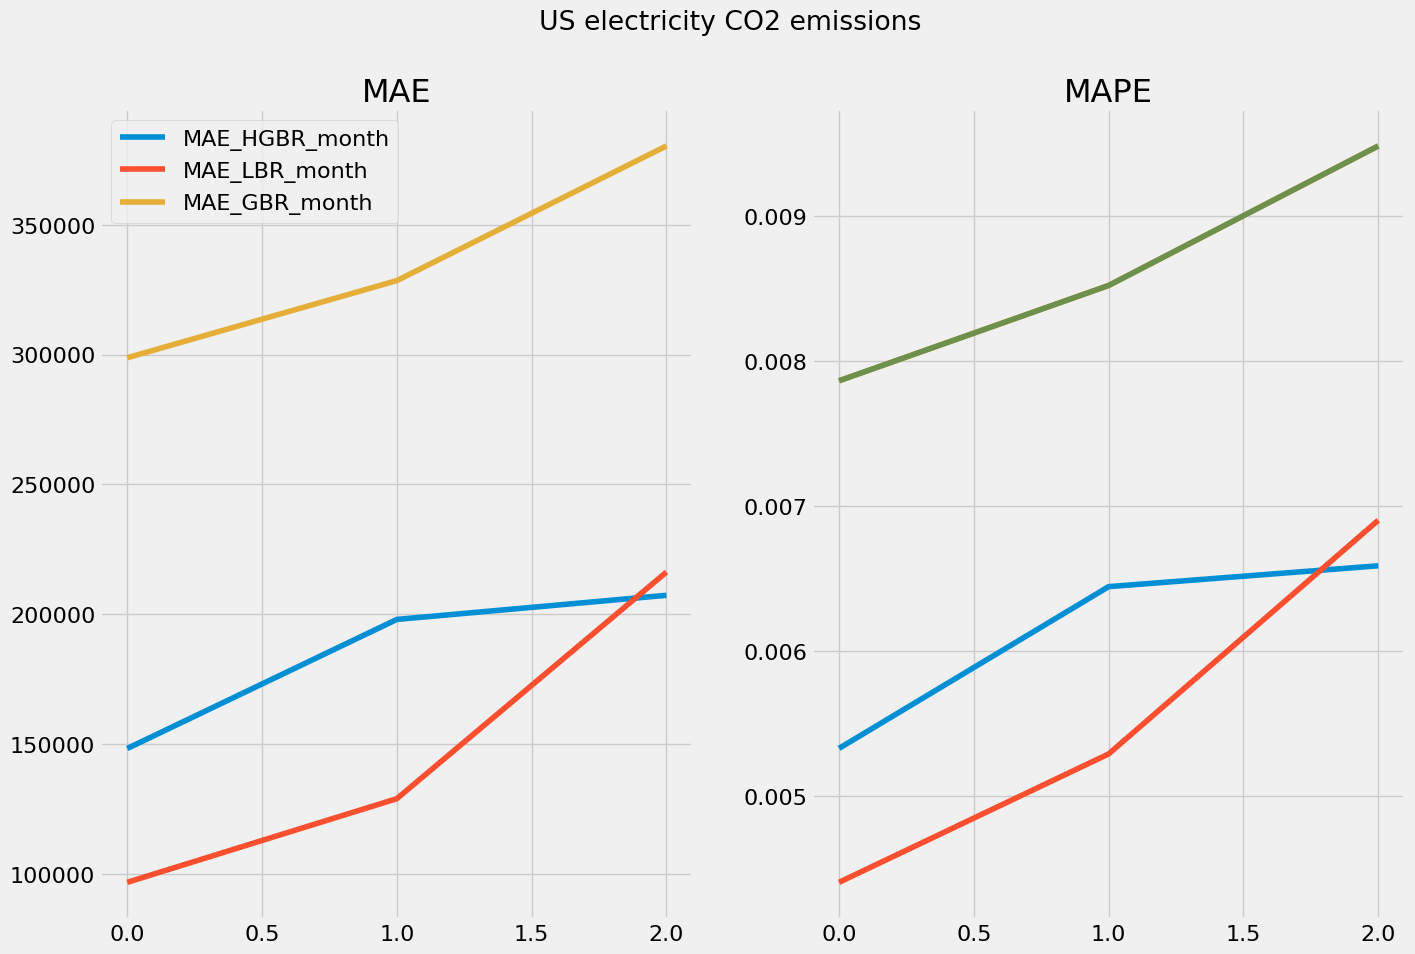

In [ ]:
### Graphique de l'ensemble des Metrics ###

fig = plt.figure(figsize=(15,10))
fig = plt.gcf()

# First subplot
ax1 = fig.add_subplot(1,2,1)
ax1.plot(MAE_HGBR_month, label="MAE_HGBR_month")
ax1.plot(MAE_LBR_month, label="MAE_LBR_month")
ax1.plot(MAE_GBR_month, label="MAE_GBR_month")
ax1.set_title('MAE')
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(1,2,2)
ax2.plot(MAPE_HGBR_month, label="MAPE_HGBR_month")
ax2.plot(MAPE_LBR_month, label="MAPE_LBR_month")
ax2.plot(MAPE_GBR_month, label="MAPE_GBR_month")
ax2.plot(MAPE_GBR_month, label="MAPE_GBR_month")
ax2.set_title('MAPE')

# Global figure methods
fig.suptitle('US electricity CO2 emissions')
plt.show()


In [ ]:
MAE = [np.mean(MAE_HGBR_month),np.mean(MAE_LBR_month),np.mean(MAE_GBR_month),np.mean(MAE_XGB_month)]
MAPE = 100*np.array([np.mean(MAPE_HGBR_month),np.mean(MAPE_LBR_month),np.mean(MAPE_GBR_month),np.mean(MAPE_XGB_month)])
models = ['HGBR','LBR',"GBR",'XGB']
pd.DataFrame({"Modele":models,"MAE":MAE,"MAPE (%)":MAPE}).sort_values('MAPE (%)')

,Modele,MAE,MAPE (%)
1,LBR,1.472887e+05,0.553226
0,HGBR,1.845005e+05,0.612028
2,GBR,3.358785e+05,0.862394
3,XGB,2.528727e+06,2.562368


# Conclusion